### Importing  Packeges

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

### Creating an Instance of the MobileNetV2

In [2]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

### Freezing All the Layers of the Model expect Top Layer

In [3]:
for layer in base_model.layers:
    layer.trainable = False

### Adding Top 3 Layers to the pre-trained Model

In [4]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.6),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(9, activation='softmax')
])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 9)                 2

### Selecting Adam Optimizer + Compiling

In [5]:
optimizer = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Loading Dataset + Data Augmentation
>#### ImageDataGenrator = **Data Augmentation**
>#### ***NO*** Data Augmentation for Validation Set
>#### Composing train & test Generators

In [6]:
target_size = (224, 224)
batch_size = 32

datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=0.2,
    vertical_flip=True,
    fill_mode='nearest', 
)
datagen_val = ImageDataGenerator(rescale=1./255, validation_split=0.15)

train_generator = datagen_train.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_val.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)


Found 161 images belonging to 9 classes.
Found 20 images belonging to 9 classes.


### Balancing Class Weights (*inorder to improve perrformace on minority classes*)

In [7]:
labels = train_generator.classes

class_counts = np.bincount(labels)
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(class_counts) * class_counts)

class_weight_dict = dict(zip(range(len(class_counts)), class_weights))

### Start Training the Model
* Fine-tuing the model on my small Dataset

In [8]:
his=model.fit(train_generator, epochs=30, validation_data=val_generator, class_weight=class_weight_dict)

Epoch 1/30
6/6 [==============================] - 29s 5s/step - loss: 10.8897 - accuracy: 0.1304 - val_loss: 9.7474 - val_accuracy: 0.3000
Epoch 2/30
6/6 [==============================] - 25s 4s/step - loss: 9.6405 - accuracy: 0.2174 - val_loss: 9.0709 - val_accuracy: 0.1500
Epoch 3/30
6/6 [==============================] - 25s 4s/step - loss: 8.5484 - accuracy: 0.2298 - val_loss: 8.2256 - val_accuracy: 0.0500
Epoch 4/30
6/6 [==============================] - 25s 5s/step - loss: 8.0764 - accuracy: 0.1988 - val_loss: 7.5761 - val_accuracy: 0.2500
Epoch 5/30
6/6 [==============================] - 25s 4s/step - loss: 7.3981 - accuracy: 0.2174 - val_loss: 6.9731 - val_accuracy: 0.3500
Epoch 6/30
6/6 [==============================] - 25s 5s/step - loss: 6.7613 - accuracy: 0.2236 - val_loss: 6.4106 - val_accuracy: 0.2500
Epoch 7/30
6/6 [==============================] - 25s 5s/step - loss: 6.3476 - accuracy: 0.2174 - val_loss: 5.9322 - val_accuracy: 0.3500
Epoch 8/30
6/6 [=================

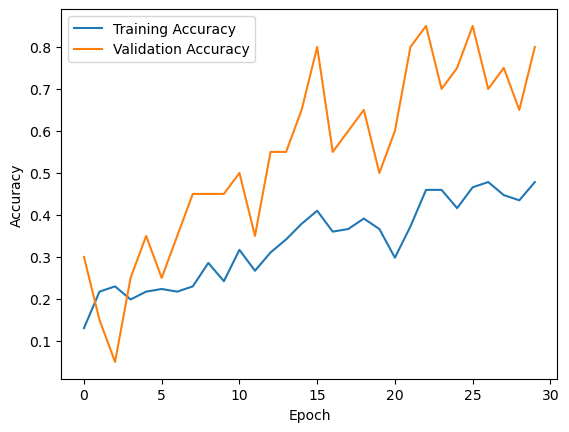

In [9]:
plt.plot(his.history['accuracy'], label='Training Accuracy')
plt.plot(his.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Defining a function to do preprocessing on images

In [10]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0 
    image = np.expand_dims(image, axis=0)  # Adding batch dimension
    return image

### Making a Dictionary of Dataset Classes

In [11]:
label_map = train_generator.class_indices
label_map = {v: k for k, v in label_map.items()}

print(label_map)

{0: 'Ghosht_Garch', 1: 'Gorme_Sabzi', 2: 'Havij', 3: 'Joje', 4: 'Kabab', 5: 'Mahi', 6: 'Makaroni', 7: 'Morgh', 8: 'Naget'}


### A function to Predict a Single Given Image

In [12]:
def predict_single_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions)

    predicted_class_label = label_map[predicted_class_index]
    
    return predicted_class_label 

In [13]:
predict_single_image('/Users/parsa/Desktop/Food/Havij/‌129.jpg')

1/1 [==============================] - 0s 343ms/step


'Havij'

### Testing Model Performance on 7 Validation Images

1/1 [==============================] - 0s 140ms/step


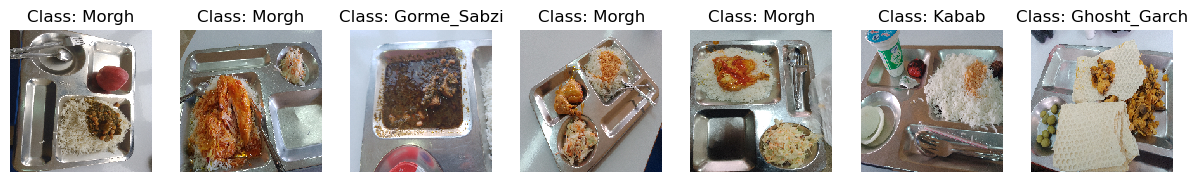

In [14]:
import matplotlib.pyplot as plt


batch = val_generator.next()
images, _ = batch

predictions = model.predict(images)

class_names = val_generator.class_indices
class_names = {v: k for k, v in class_names.items()}


num_images_to_display = 7

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5)) 

for i in range(num_images_to_display):
    axes[i].imshow(images[i], interpolation='nearest')  
    axes[i].set_title(f"Class: {class_names[np.argmax(predictions[i])]}")
    axes[i].axis('off')

plt.show()


In [19]:
target_size = (224, 224)

datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.3,
    brightness_range=[0.6, 1.8],
    channel_shift_range=0.2,
    vertical_flip=True,
    fill_mode='nearest', 
)
datagen_val = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_generator = datagen_train.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_val.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)


Found 161 images belonging to 9 classes.
Found 37 images belonging to 9 classes.


In [20]:
his=model.fit(train_generator, epochs=20, validation_data=val_generator, class_weight=class_weight_dict)

Epoch 1/20
3/3 [==============================] - 25s 11s/step - loss: 2.7022 - accuracy: 0.4596 - val_loss: 2.2695 - val_accuracy: 0.7297
Epoch 2/20
3/3 [==============================] - 22s 7s/step - loss: 2.8505 - accuracy: 0.4720 - val_loss: 2.2099 - val_accuracy: 0.7027
Epoch 3/20
3/3 [==============================] - 22s 7s/step - loss: 2.7814 - accuracy: 0.4845 - val_loss: 2.2024 - val_accuracy: 0.8378
Epoch 4/20
3/3 [==============================] - 22s 7s/step - loss: 2.5231 - accuracy: 0.5590 - val_loss: 2.2472 - val_accuracy: 0.8378
Epoch 5/20
3/3 [==============================] - 22s 9s/step - loss: 2.5210 - accuracy: 0.5714 - val_loss: 2.2344 - val_accuracy: 0.7838
Epoch 6/20
3/3 [==============================] - 22s 7s/step - loss: 2.3846 - accuracy: 0.5652 - val_loss: 2.1713 - val_accuracy: 0.8378
Epoch 7/20
3/3 [==============================] - 22s 7s/step - loss: 2.3922 - accuracy: 0.5901 - val_loss: 2.1272 - val_accuracy: 0.8378
Epoch 8/20
3/3 [=================

In [21]:
his=model.fit(train_generator, epochs=15, validation_data=val_generator, class_weight=class_weight_dict)

Epoch 1/15
3/3 [==============================] - 25s 11s/step - loss: 1.9930 - accuracy: 0.6832 - val_loss: 1.6128 - val_accuracy: 0.8919
Epoch 2/15
3/3 [==============================] - 22s 7s/step - loss: 1.8594 - accuracy: 0.7205 - val_loss: 1.6321 - val_accuracy: 0.8649
Epoch 3/15
3/3 [==============================] - 22s 9s/step - loss: 2.0081 - accuracy: 0.6398 - val_loss: 1.6334 - val_accuracy: 0.8649
Epoch 4/15
3/3 [==============================] - 22s 7s/step - loss: 1.9208 - accuracy: 0.6708 - val_loss: 1.5916 - val_accuracy: 0.8378
Epoch 5/15
3/3 [==============================] - 22s 7s/step - loss: 1.8690 - accuracy: 0.6770 - val_loss: 1.5718 - val_accuracy: 0.8919
Epoch 6/15
3/3 [==============================] - 22s 7s/step - loss: 1.9521 - accuracy: 0.6894 - val_loss: 1.5657 - val_accuracy: 0.8919
Epoch 7/15
3/3 [==============================] - 22s 7s/step - loss: 1.7486 - accuracy: 0.7453 - val_loss: 1.6024 - val_accuracy: 0.8919
Epoch 8/15
3/3 [=================

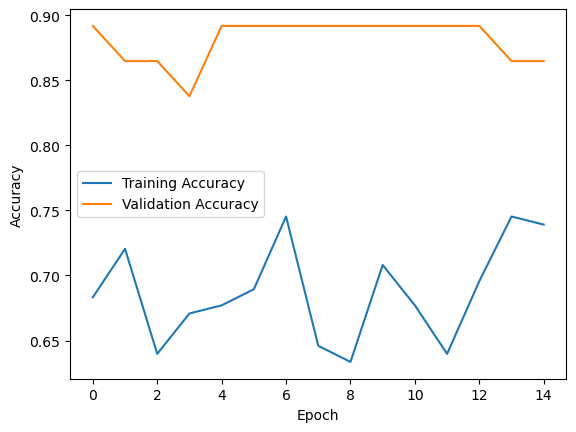

In [22]:
plt.plot(his.history['accuracy'], label='Training Accuracy')
plt.plot(his.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Making new Data Geneartors but without doing Data Augmentation Stuff
#### (just Original Images)

In [23]:
datagen_train2 = ImageDataGenerator(rescale=1./255)
datagen_val2 = ImageDataGenerator(rescale=1./255, validation_split=0.20)


train_generator2 = datagen_train2.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator2 = datagen_val2.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 161 images belonging to 9 classes.
Found 29 images belonging to 9 classes.


### Again, Fine-Tuning the Above Model but Only with Original Data
#### just to make the training procedure a bit simpler

In [24]:
history = model.fit(train_generator2, epochs=16, validation_data=val_generator2)

Epoch 1/16
6/6 [==============================] - 23s 4s/step - loss: 1.7255 - accuracy: 0.7702 - val_loss: 1.3393 - val_accuracy: 0.9310
Epoch 2/16
6/6 [==============================] - 20s 4s/step - loss: 1.6820 - accuracy: 0.7391 - val_loss: 1.2568 - val_accuracy: 0.9310
Epoch 3/16
6/6 [==============================] - 20s 3s/step - loss: 1.7689 - accuracy: 0.7143 - val_loss: 1.2755 - val_accuracy: 0.9310
Epoch 4/16
6/6 [==============================] - 20s 4s/step - loss: 1.6962 - accuracy: 0.7205 - val_loss: 1.2331 - val_accuracy: 0.9310
Epoch 5/16
6/6 [==============================] - 20s 4s/step - loss: 1.6640 - accuracy: 0.7267 - val_loss: 1.1981 - val_accuracy: 0.9655
Epoch 6/16
6/6 [==============================] - 20s 4s/step - loss: 1.5450 - accuracy: 0.8199 - val_loss: 1.1772 - val_accuracy: 0.9655
Epoch 7/16
6/6 [==============================] - 20s 3s/step - loss: 1.4804 - accuracy: 0.8509 - val_loss: 1.1215 - val_accuracy: 1.0000
Epoch 8/16
6/6 [==================

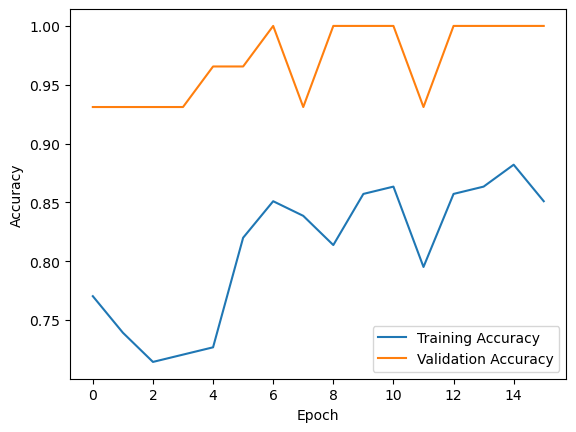

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
target_size = (224, 224)
batch_size = 32

datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=0.2,
    vertical_flip=True,
    fill_mode='nearest', 
)
datagen_val = ImageDataGenerator(rescale=1./255, validation_split=0.16)

train_generator = datagen_train.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_val.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
)


Found 161 images belonging to 9 classes.
Found 21 images belonging to 9 classes.


In [30]:
his=model.fit(train_generator, epochs=20, validation_data=val_generator, class_weight=class_weight_dict)

Epoch 1/20
3/3 [==============================] - 20s 6s/step - loss: 1.5722 - accuracy: 0.6646 - val_loss: 1.0848 - val_accuracy: 1.0000
Epoch 2/20
3/3 [==============================] - 20s 8s/step - loss: 1.7259 - accuracy: 0.6708 - val_loss: 1.0517 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 20s 6s/step - loss: 1.7090 - accuracy: 0.6646 - val_loss: 1.0514 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 20s 6s/step - loss: 1.5575 - accuracy: 0.6957 - val_loss: 1.0521 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 20s 6s/step - loss: 1.4817 - accuracy: 0.7081 - val_loss: 1.0748 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 20s 6s/step - loss: 1.5623 - accuracy: 0.6894 - val_loss: 1.0791 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 20s 7s/step - loss: 1.5091 - accuracy: 0.6957 - val_loss: 1.0446 - val_accuracy: 1.0000
Epoch 8/20
3/3 [==================

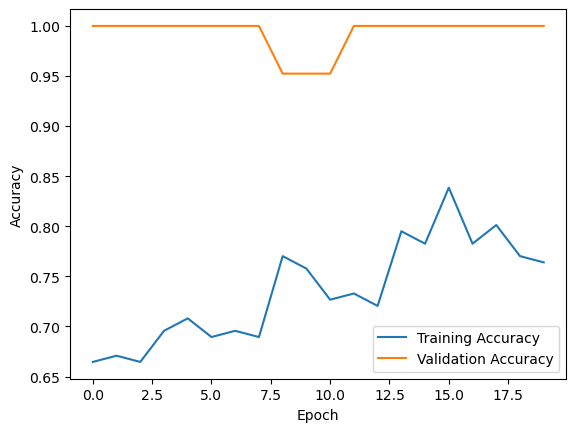

In [31]:
plt.plot(his.history['accuracy'], label='Training Accuracy')
plt.plot(his.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
target_size = (224, 224)

datagen_train = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=0.2,
    vertical_flip=True,
    fill_mode='nearest', 
)
datagen_val = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen_train.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_val.flow_from_directory(
    '/Users/parsa/Desktop/Food',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
)


Found 161 images belonging to 9 classes.
Found 29 images belonging to 9 classes.


In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [34]:
his=model.fit(train_generator, epochs=30, validation_data=val_generator, class_weight=class_weight_dict, callbacks = [callback])

Epoch 1/30
3/3 [==============================] - 24s 10s/step - loss: 1.3040 - accuracy: 0.7888 - val_loss: 0.8583 - val_accuracy: 1.0000
Epoch 2/30
3/3 [==============================] - 21s 7s/step - loss: 1.1557 - accuracy: 0.8447 - val_loss: 0.8613 - val_accuracy: 1.0000
Epoch 3/30
3/3 [==============================] - 21s 7s/step - loss: 1.2200 - accuracy: 0.8075 - val_loss: 0.8619 - val_accuracy: 0.9655
Epoch 4/30
3/3 [==============================] - 21s 9s/step - loss: 1.2884 - accuracy: 0.7391 - val_loss: 0.8473 - val_accuracy: 0.9655
Epoch 5/30
3/3 [==============================] - 21s 7s/step - loss: 1.2946 - accuracy: 0.8075 - val_loss: 0.8302 - val_accuracy: 1.0000


#### Testing Model on 7 Validation Images

1/1 [==============================] - 3s 3s/step


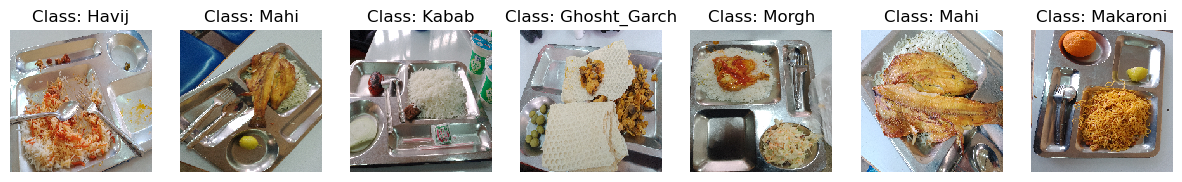

In [35]:
import matplotlib.pyplot as plt

batch = val_generator2.next()

images, _ = batch
predictions = model.predict(val_generator2)


num_images_to_display = 7

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    axes[i].imshow(images[i], interpolation='nearest') 
    axes[i].set_title(f"Class: {class_names[np.argmax(predictions[i])]}")
    axes[i].axis('off') 

plt.show()

### Plotting Training History for both Validation and Training Accuracy

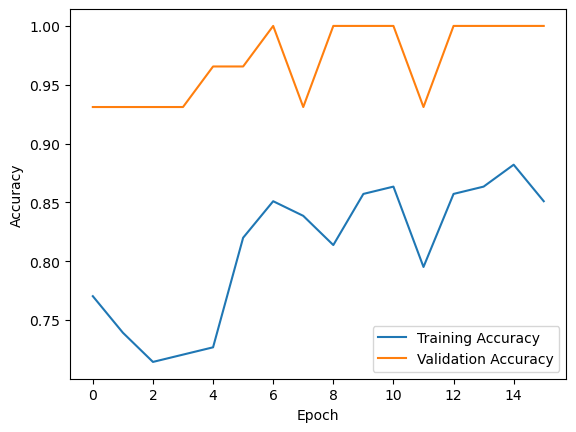

In [36]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
model.save('/Users/parsa/Desktop/trained_model_final2')

INFO:tensorflow:Assets written to: /Users/parsa/Desktop/trained_model_final2/assets


INFO:tensorflow:Assets written to: /Users/parsa/Desktop/trained_model_final2/assets


### Predicting bunch of Training Images

2/2 [==============================] - 0s 193ms/step


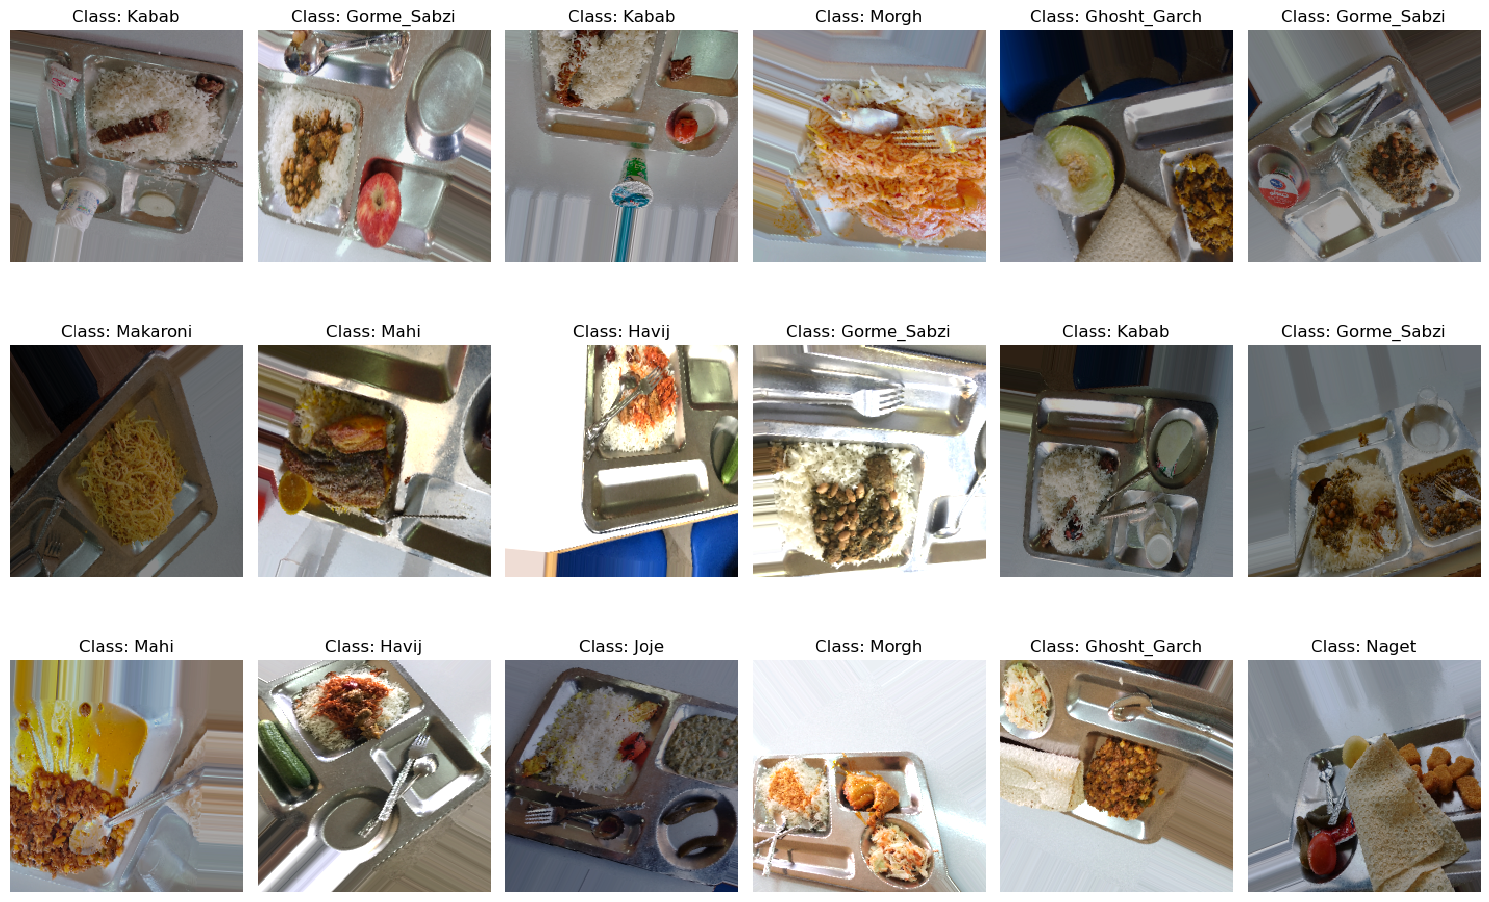

In [39]:
batch = train_generator.next()
images, labels = batch
predictions = model.predict(images)


fig, axes = plt.subplots(3, 6, figsize=(15, 10))  

for i in range(3):
    for j in range(6):
        index = i * 6 + j
        axes[i, j].imshow(images[index], interpolation='nearest')
        axes[i, j].set_title(f"Class: {class_names[np.argmax(predictions[index])]}")
        axes[i, j].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

### Predicting a Single Desired Image + Confidence Percentage

In [5]:
from tensorflow.keras.preprocessing import image


img = image.load_img("/Users/parsa/Desktop/‌140.jpg", target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)/255.0


predictions = model.predict(img_array)

predicted_class = class_names[np.argmax(predictions[0])]
confidence = predictions[0][np.argmax(predictions[0])]

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2%}")

1/1 [==============================] - 0s 37ms/step
Predicted Class: Joje
Confidence: 98.56%


### Applying Confidence Rate for new some training Images

2/2 [==============================] - 0s 20ms/step


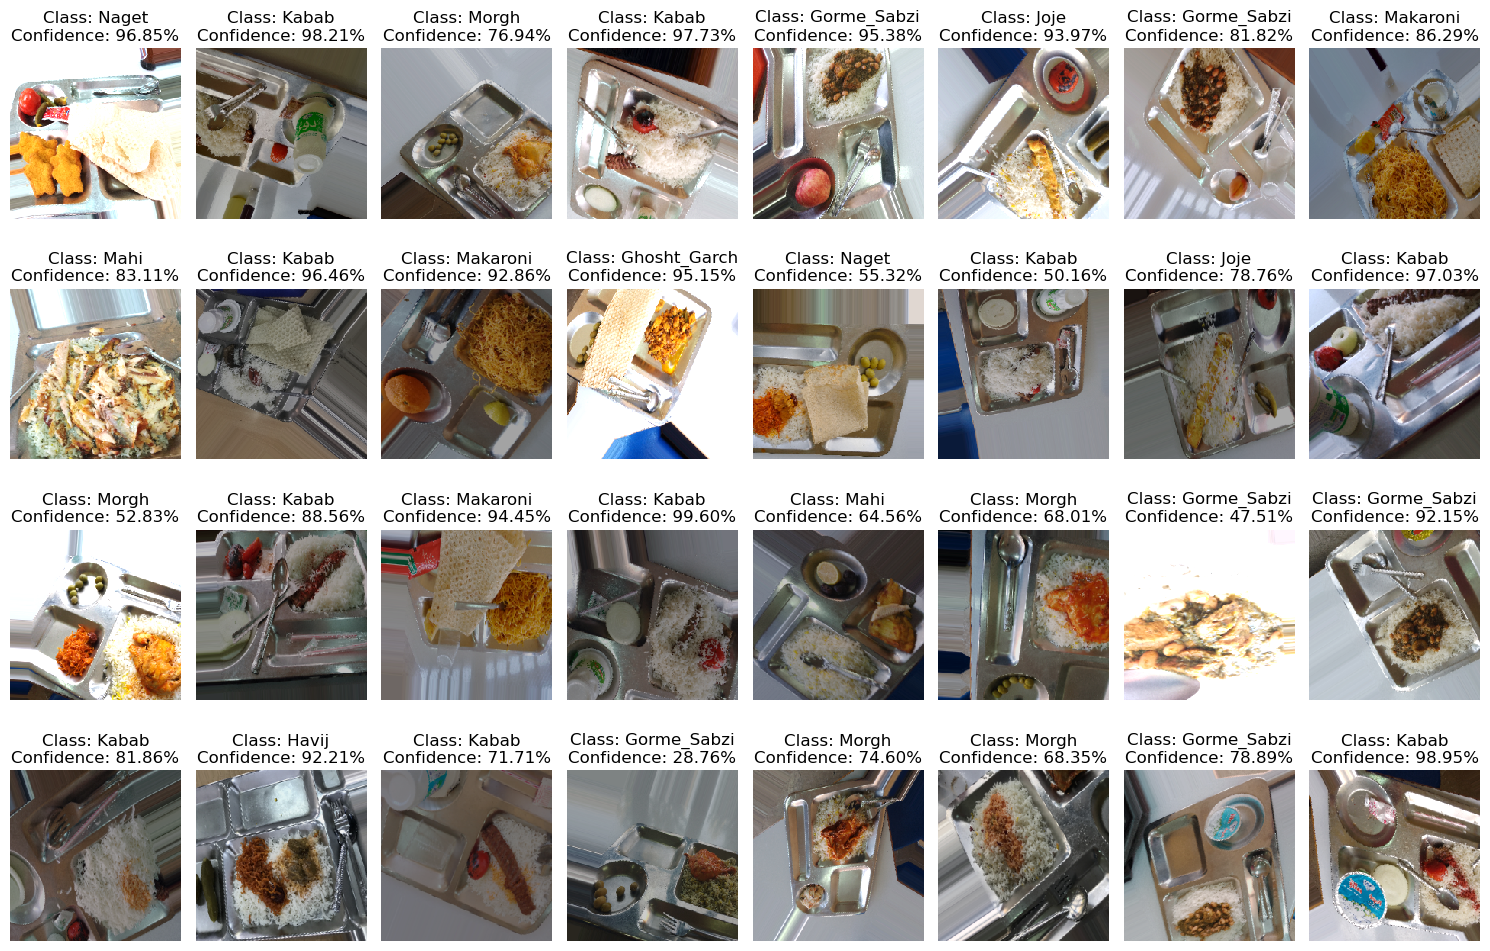

In [41]:
batch = train_generator.next()

images, labels = batch
predictions = model.predict(images)


fig, axes = plt.subplots(4, 8, figsize=(15, 10))

for i in range(4):
    for j in range(8):
        index = i*8 + j
        axes[i, j].imshow(images[index], interpolation='nearest') 
        predicted_class = class_names[np.argmax(predictions[index])]
        confidence = predictions[index][np.argmax(predictions[index])]
        axes[i, j].axis('off') 
        axes[i, j].set_title(f"Class: {predicted_class}\nConfidence: {confidence:.2%}")

plt.tight_layout()
plt.show()

### Simple Model Evaluation on Training Generator with Augmented Images
> * Confusion Matrix
> * Classification Report

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

images, true_labels = train_generator.next()
predictions = model.predict(images)
predictedLabels = np.argmax(predictions, axis=1)

array_true_labels = np.argmax(true_labels, axis=1)

conf_matrix = confusion_matrix(array_true_labels, predictedLabels)
class_report = classification_report(array_true_labels, predictedLabels)

print(class_report)
print(conf_matrix)

2/2 [==============================] - 1s 234ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.83      1.00      0.91        10
           2       1.00      0.89      0.94         9
           3       1.00      1.00      1.00         2
           4       0.92      0.85      0.88        13
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         4
           7       0.93      0.88      0.90        16
           8       1.00      1.00      1.00         1

    accuracy                           0.92        64
   macro avg       0.94      0.96      0.94        64
weighted avg       0.93      0.92      0.92        64

[[ 6  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  1  0]
 [ 0  0  0  2  0  0  0  0  0]
 [ 0  2  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  1  1  0 14  0]
 [